<a href="https://colab.research.google.com/github/anyaconda/myStats/blob/master/mySpearmanSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spearman Simulation

In [1]:
#meta 4/2/2021 Explore Spearman's Correlation - Daniel's Simulation

#history
#     4/3/2021 Add Continuous vs Categorical variables
#     Added vis

#     4/4/2021 Modified vis - added opacity to scatter plots
#     Opacity helps with visualizing data volumes

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

## Data Setup
Continuous Target, Categorical Label

In [3]:
true_target = np.arange(0,5000) / 4999
label = []

dist = {0:250,
       0.25:1000,
       0.5:2500,
       0.75:1000,
       1:250}

for lab, rep in dist.items():
    label.extend([lab]*rep)
label = np.array(label)
label.min(), label.max(), label.mean()

(0.0, 1.0, 0.5)

In [4]:
#categorical label
unique, counts = np.unique(label, return_counts=True)
unique, counts

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([ 250, 1000, 2500, 1000,  250]))

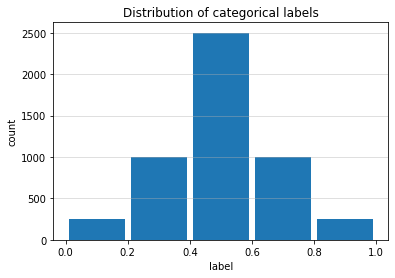

In [5]:
#vis categorical labels
plt.hist(label, bins=5, rwidth=0.9)
plt.xlabel('label')
plt.ylabel('count')
plt.title('Distribution of categorical labels')
plt.grid(axis='y', alpha=0.5)

# Some Simple Test Cases
## Case 1: Exactly correct predictions (Continuous)
Perfect correlation in perfect order.  
This is just to make sure the most obvious case works as anticipated.

In [6]:
#Continuous target, Continuous predictions
preds = np.arange(0,5000) / 4999
spearmanr(preds, true_target)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)

In [7]:
# calculate spearman's correlation with Scipy
coef, p = spearmanr(true_target, preds)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9999999999999999
Samples are correlated (reject H0) p=0.0000


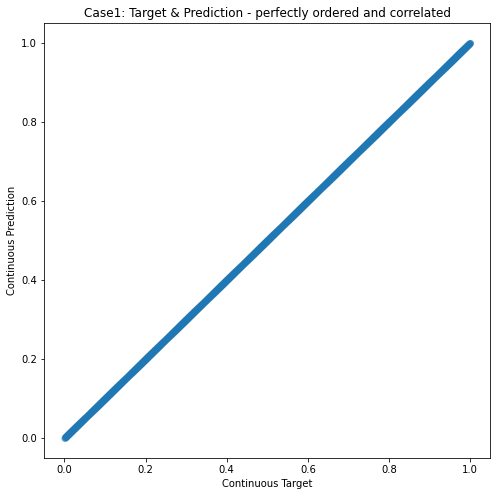

In [8]:
#visualize raw input already perfectly ordered and correlated
plt.figure(figsize=(8,8))
plt.scatter(true_target,preds, alpha=.1);
plt.title("Case1: Target & Prediction - perfectly ordered and correlated");
plt.xlabel('Continuous Target');
plt.ylabel('Continuous Prediction');


## Case 2: Randomized
Another mostly-obvious case. What degree of ordering could we expect by shuffling our predictions?

In [9]:
preds = np.arange(0,5000) / 4999
shuffle_corr = []
for i in range(5000):
    np.random.shuffle(preds)
    shuffle_corr.append(spearmanr(preds,true_target)[0])  
    

In [10]:
shuffle_corr = np.array(shuffle_corr)
shuffle_corr.mean()

-0.0001557618976224759

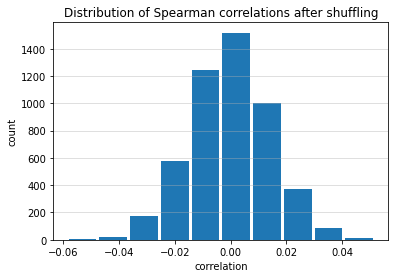

In [11]:
plt.hist(shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('Distribution of Spearman correlations after shuffling')
plt.grid(axis='y', alpha=0.5)

## Case 2a.  Randomized Sorted

In [12]:
# calculate spearman's correlation with Scipy
coef, p = spearmanr(true_target, sorted(preds))
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9999999999999999
Samples are correlated (reject H0) p=0.0000


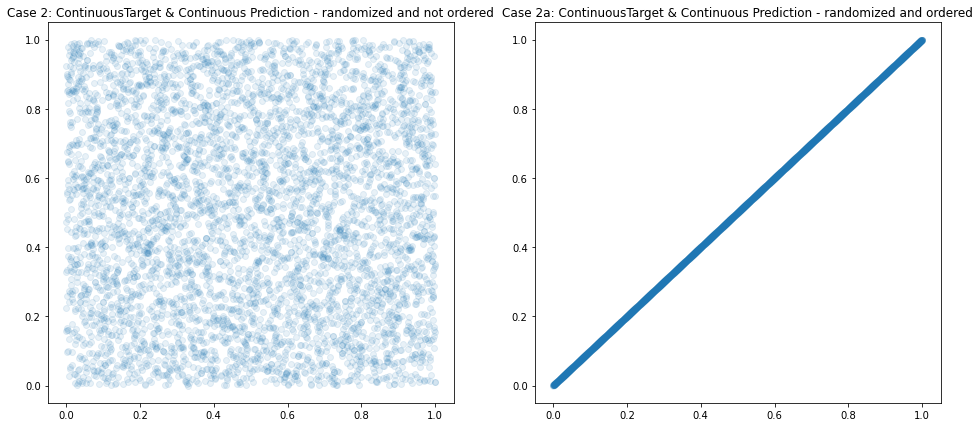

In [13]:
#visualize raw input and ordered input
_,ax = plt.subplots(1,2, figsize=(16,7))
ax[0].scatter(true_target,preds, alpha=.1);
ax[0].title.set_text("Case 2: ContinuousTarget & Continuous Prediction - randomized and not ordered");
ax[1].scatter(true_target,sorted(preds), alpha=.1);
ax[1].title.set_text("Case 2a: ContinuousTarget & Continuous Prediction - randomized and ordered");

Now we have the simplest of baselines:    
Case 1. The spearman correlation of an ordered array with itself is 1;  
Case 2. The average spearman correlation of an ordered array with that same array randomly shuffled is zero.  
Case 2a. If randomly shuffled array is sorted, then the Spearman correlation is 1 again.  

## Case 3: Categorical Predictions
identical results by label

What happens if we try to get the correlation with only five values? Basically, if the labels (0, 0.25, ..., 1) are the predictions?

In [14]:
#Continuous target, Categorical predictions
preds = label
spearmanr(preds, true_target)

SpearmanrResult(correlation=0.9266876681762855, pvalue=0.0)

In [15]:
coef, p = spearmanr(preds, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9266876681762855
Samples are correlated (reject H0) p=0.0000


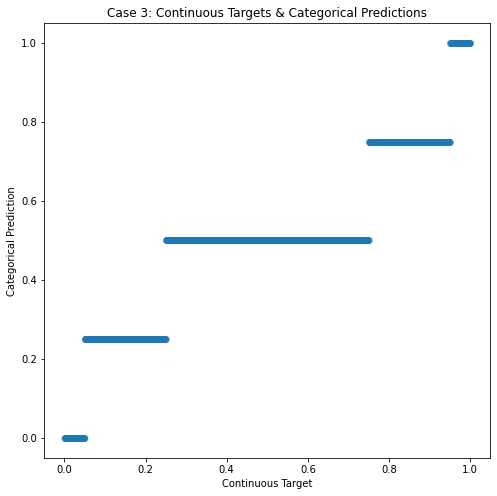

In [16]:
#visualize raw input already ordered, correlation is not perfect but still statistically significant
plt.figure(figsize=(8,8))
plt.scatter(true_target,preds, alpha=.1);
plt.title("Case 3: Continuous Targets & Categorical Predictions");
plt.xlabel('Continuous Target');
plt.ylabel('Categorical Prediction');

Interesting -- still an extremely high correlation, but not exactly 1.

Now the real question: what if the results *within each label* are shuffled? That is, if we correctly predict each label, but then within each label we randomly order the results? Let's construct a DataFrame to better visualize.

In [17]:
#shuffle predictions
labelcat = pd.Categorical(label)
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target, 'pred':np.zeros_like(true_target)})

In [18]:
#Continuous predictions, randomized withing category
pred = []
for label in df.Label.unique():
    ordered = df.loc[df.Label==label, 'true_target']
    shuffled = list(ordered)
    np.random.shuffle(shuffled)
    pred.extend(shuffled)

The below test show that `pred` is not ordered, BUT that the preds in each category are lower than the preds in each subsequent category. (not comprehensive)

In [19]:
all(pred[i] <= pred[i+1] for i in range(len(pred)-1)), np.all(pred[0:250] < pred[250:1250]), np.mean(pred[0:250]), np.mean(pred[4750:])

(False, True, 0.02490498099619924, 0.9750950190038008)

In [20]:
#preview - preds randomized
#pred[:10] #not ordered

#each category stats
(min(pred[:250]), max(pred[:250]), np.mean(pred[:250])), (min(pred[250:1250]), max(pred[250:1250]), np.mean(pred[250:1250])), (min(pred[1250:3750]), max(pred[1250:3750]), np.mean(pred[1250:3750])), (min(pred[3750:4750]), max(pred[3750:4750]), np.mean(pred[3750:4750])), (min(pred[4750:]), max(pred[4750:]), np.mean(pred[4750:]))


((0.0, 0.04980996199239848, 0.02490498099619924),
 (0.05001000200040008, 0.2498499699939988, 0.14992998599719945),
 (0.2500500100020004, 0.7499499899979996, 0.5),
 (0.7501500300060012, 0.9499899979995999, 0.8500700140028006),
 (0.9501900380076015, 1.0, 0.9750950190038008))

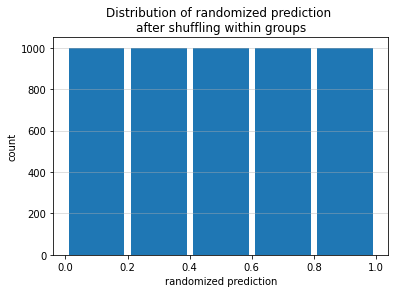

In [21]:
#vis distribution of continuous randomized predictions
plt.hist(pred, bins=5, rwidth=0.9)
plt.xlabel('randomized prediction')
plt.ylabel('count')
plt.title('Distribution of randomized prediction \nafter shuffling within groups')
plt.grid(axis='y', alpha=0.5)

Let's try this shuffling process a bunch of times and take the correlations.

In [22]:
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target})
corrs = []
for i in range(5000):
    pred=[]
    for label in df.Label.unique():
        ordered = df.loc[df.Label==label, 'true_target']
        shuffled = list(ordered)
        np.random.shuffle(shuffled)
        #np.flip(shuffled)
        pred.extend(shuffled)
    corrs.append(spearmanr(pred,true_target)[0])

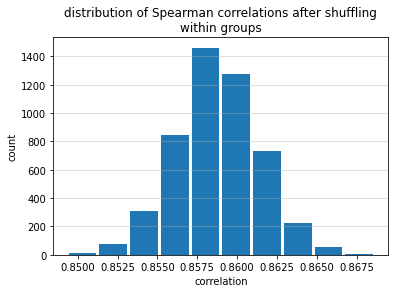

In [23]:
group_shuffle_corr = np.array(corrs)
plt.hist(group_shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('distribution of Spearman correlations after shuffling\nwithin groups')
plt.grid(axis='y', alpha=0.5)

In [24]:
np.mean(corrs)

0.8587418185499606

## Case 3a: Categorical Predictions
identical results by label, ordered

What happens if we try to get the correlation with only five values? Basically, if the labels (0, 0.25, ..., 1) are the predictions?

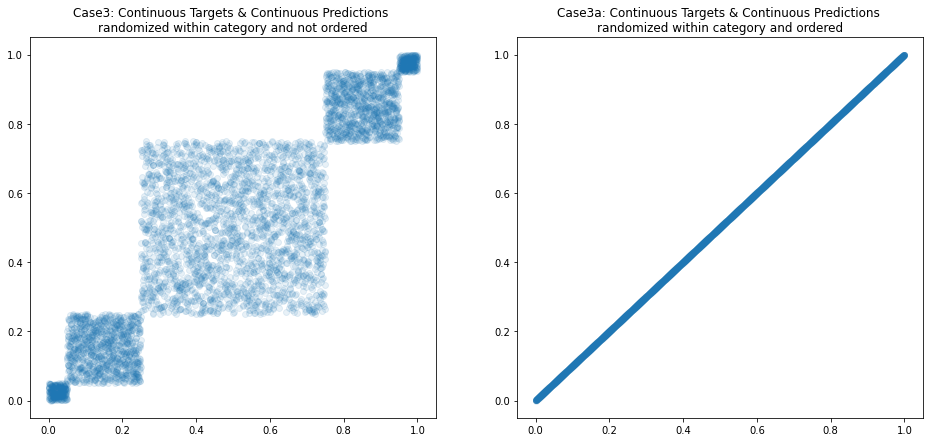

In [25]:
#visualize raw input and ordered input
_,ax = plt.subplots(1,2, figsize=(16,7))
ax[0].scatter(true_target,pred, alpha=.1);
ax[0].title.set_text("Case3: Continuous Targets & Continuous Predictions \nrandomized within category and not ordered");
ax[1].scatter(true_target,sorted(pred), alpha=.1);
ax[1].title.set_text("Case3a: Continuous Targets & Continuous Predictions \nrandomized within category and ordered");

In [26]:
coef, p = spearmanr(pred, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.8624809617952383
Samples are correlated (reject H0) p=0.0000


In [27]:
coef, p = spearmanr(sorted(preds), true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9266876681762855
Samples are correlated (reject H0) p=0.0000


## Case 4: Using only Two Categories

In [28]:
true_target = np.arange(0,5000) / 4999
label = []

dist = {'low': 3500,
        'high':1500}

for lab, rep in dist.items():
    label.extend([lab]*rep)
label = np.array(label)
label

array(['low', 'low', 'low', ..., 'high', 'high', 'high'], dtype='<U4')

In [29]:
labelcat = pd.Categorical(label)
df = pd.DataFrame({'Label':labelcat, 'true_target':true_target})
corrs = []
for i in range(5000):
    pred=[]
    for label in df.Label.unique():
        ordered = df.loc[df.Label==label, 'true_target']
        shuffled = list(ordered)
        np.random.shuffle(shuffled)
        #np.flip(shuffled)
        pred.extend(shuffled)
    corrs.append(spearmanr(pred,true_target)[0])

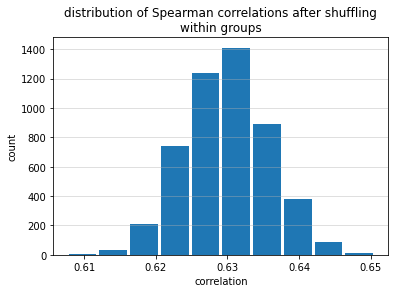

In [30]:
group_shuffle_corr = np.array(corrs)
plt.hist(group_shuffle_corr, bins=10, rwidth=0.9)
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('distribution of Spearman correlations after shuffling\nwithin groups')
plt.grid(axis='y', alpha=0.5)

In [31]:
np.mean(group_shuffle_corr)

0.6298871299916131

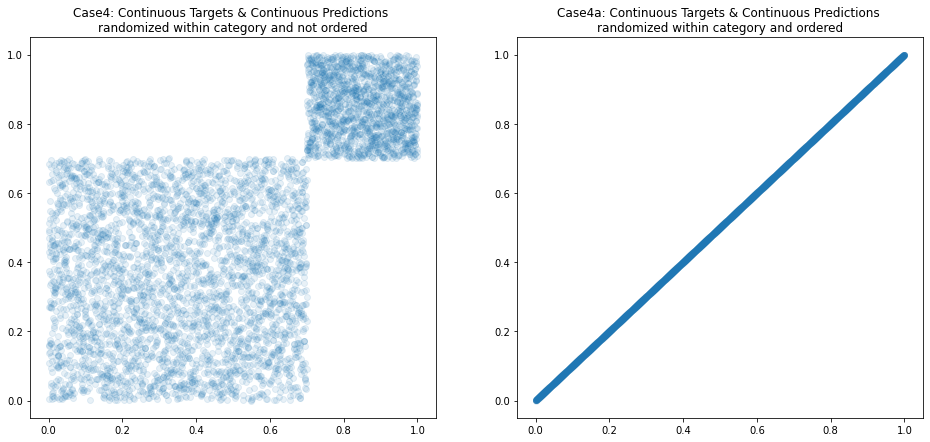

In [32]:
#visualize raw input and ordered input
_,ax = plt.subplots(1,2, figsize=(16,7))
ax[0].scatter(true_target,pred, alpha=.1);
ax[0].title.set_text("Case4: Continuous Targets & Continuous Predictions \nrandomized within category and not ordered");
ax[1].scatter(true_target,sorted(pred), alpha=.1);
ax[1].title.set_text("Case4a: Continuous Targets & Continuous Predictions \nrandomized within category and ordered");

In [33]:
coef, p = spearmanr(pred, true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.6303947915197916
Samples are correlated (reject H0) p=0.0000


In [34]:
coef, p = spearmanr(sorted(preds), true_target)
print('Spearmans correlation coefficient:', coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.4f' % p)
else:
    print('Samples are correlated (reject H0) p=%.4f' % p)

Spearmans correlation coefficient: 0.9266876681762855
Samples are correlated (reject H0) p=0.0000
